# ImageNet Classification with Deep Convolutional Neural Networks

In this paper a large Deep CNN was trained to classify the ImageNet dataset. The research paper can be obtained from [here](http://papers.nips.cc/paper/4824-imagenet-classification-with-deep-convolutional-neural-networks.pdf).

I will be implementing the paper, however I will not use the ImageNet dataset as it took 6 days to train the CNN while using two GTX 580 3GB GPUs. Since I cannot afford to give so much time for training, I will be using a much smaller dataset. The objective of this exercise is to learn image classification using CNNs and gain experience for implementing papers and get hands-on practice.

The dataset used for this project is the ASIRRA Dogs vs Cats dataset which is provided in Kaggle and is available [here](https://www.kaggle.com/competitions/dogs-vs-cats/data)


## About the paper

The objective of this paper is to find an efficient method to train a large dataset for object detection from images. The dataset used for this paper is the [ImageNet](https://www.image-net.org/) dataset which contains 15 million high resolution images for over 22,000 categories. A model with large training capacity is required for such a task.

**Specific Contributions**

- A highly optimized GPU implementation for 2D convolutions and all other operations for training a CNN.
- The training is spread into 2 GPUs and the GPUs communicate only in certain layers. This improves the speed

**The code**

- The final network contians 5 convolutional and 3 fully-connected layers.
- The images were resized to 256 x 256 resolution. No preprocessing was done to the images.

In [69]:
#Import deep learning libraries
from tensorflow.keras.layers import Dense, MaxPooling2D, Dropout, Conv2D, Lambda, Flatten, BatchNormalization, Lambda
from tensorflow.keras.layers import Resizing, Rescaling, RandomFlip, RandomRotation
from tensorflow.keras.activations import relu, softmax
from tensorflow.keras.utils import plot_model
from tensorflow.nn import local_response_normalization
from tensorflow.keras.models import Sequential
from tensorflow import keras
import tensorflow
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from zipfile import ZipFile
import matplotlib.pyplot as plt
import cv2
import glob
import pandas as pd
import numpy as np
import os

### Getting the data

All the training and testing data is present as a zip file. We need to extract the zip files into folders containing the train and test data

In [3]:
zipf = ZipFile('/kaggle/input/dogs-vs-cats/train.zip', 'r')
zipf.extractall(path=r'./')
ZipFile('/kaggle/input/dogs-vs-cats/test1.zip', 'r').extractall()

In [9]:
train_data = glob.glob('/kaggle/working/train/*.jpg')
train_class = [x.split('/')[4].split('.')[0] for x in train_data]
training_data = pd.DataFrame({'filename':train_data, 'class':train_class})
training_data.head()

,filename,class
0,/kaggle/working/train/cat.11966.jpg,cat
1,/kaggle/working/train/cat.5998.jpg,cat
2,/kaggle/working/train/dog.5178.jpg,dog
3,/kaggle/working/train/cat.4762.jpg,cat
4,/kaggle/working/train/dog.4466.jpg,dog


After extracting all the images we now need to convert them into numpy arrays. These numpy arrays will act as input layers for the CNN. Moreover, the images need to be resized into a standard size(224 given in the paper).

The data will labelled as:

Dog $\rightarrow$ 0

Cat $\rightarrow$ 1

Now we will perform splitting of the data into into training and validation. This way we can reduce overfitting.

To get the image into the CNN, we will use the `ImageDataGenerator` class from `tensorflow`

In [12]:
#creating the generator for augmentation and later splitting the data into training and validation
img_gen = ImageDataGenerator(
        rotation_range=0.2,
        width_shift_range=0.05,
        height_shift_range=0.05,
        shear_range=0.05,
        zoom_range=0.05,
        horizontal_flip=True,
        vertical_flip=True,
        validation_split=0.2)

SIZE=224
BATCH=128

In [13]:
training = img_gen.flow_from_dataframe(
        training_data,
        target_size=(SIZE,SIZE),
        batch_size=BATCH,
        class_mode='categorical',
        subset='training')
validation = img_gen.flow_from_dataframe(
        training_data,
        target_size=(SIZE,SIZE),
        batch_size=BATCH,
        class_mode='categorical',
        subset='validation')

Found 20000 validated image filenames belonging to 2 classes.
Found 5000 validated image filenames belonging to 2 classes.


## Creating the CNN

After the preprocessing on the data has been done, we can now begin to create the CNN by adding layers to it. We will stick to the original `AlexNet` paper and create a CNN with 8 layers.

In [72]:
from tensorflow.keras.layers import Input

#creating the CNN model
model = Sequential(name="AlexNet")
model.add(Input(shape=(224,224,3)))
#the 1st layer
model.add(Conv2D(96, (11,11), strides=(4, 4), activation=relu))
model.add(BatchNormalization())
model.add(MaxPooling2D()) #using (2,2) as no dimensions have been mentioned
model.add(Lambda(local_response_normalization))
        
#the 2nd layer
model.add(Conv2D(filters=256, kernel_size=(5,5), activation=relu))
model.add(BatchNormalization())
model.add(MaxPooling2D())
model.add(Lambda(local_response_normalization))
        
#the 3rd, 4th and 5th layers
model.add(Conv2D(384, (3,3), activation=relu))
model.add(Conv2D(384, (3,3), activation=relu))
model.add(Conv2D(256, (3,3), activation=relu))

#flatten the output of the CNN layer to be inserted into the Dense layer
model.add(Flatten())

#the 6th layer(Dense layer)
model.add(Dense(4096, activation=relu))
model.add(Dropout(0.5))
#the 7th layer(Dense layer)
model.add(Dense(4096, activation=relu))
model.add(Dropout(0.5))
        
#the 8th and last layer(Softmax activation)
model.add(Dense(2, activation=softmax))

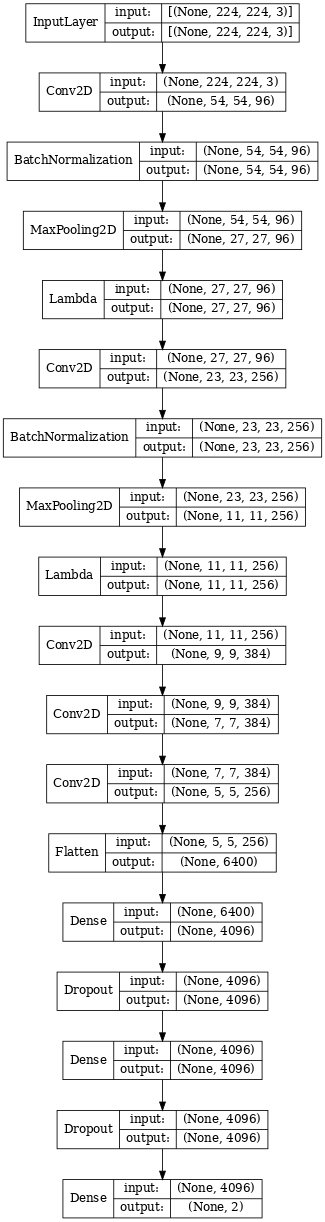

In [73]:
plot_model(model, show_shapes=True, show_layer_names=False, dpi=60)

In [74]:
model.summary()

Model: "AlexNet"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_17 (Conv2D)           (None, 54, 54, 96)        34944     
_________________________________________________________________
batch_normalization_6 (Batch (None, 54, 54, 96)        384       
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 27, 27, 96)        0         
_________________________________________________________________
lambda_2 (Lambda)            (None, 27, 27, 96)        0         
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 23, 23, 256)       614656    
_________________________________________________________________
batch_normalization_7 (Batch (None, 23, 23, 256)       1024      
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 11, 11, 256)       0   

In [77]:
#training the model
# opt = tensorflow.keras.optimizers.SGD(learning_rate=0.00001, momentum=0.9)
model.compile(loss="categorical_crossentropy",
             optimizer='sgd',
             metrics=['accuracy'])

In [78]:
history = model.fit(training,
                   epochs=10,
                   validation_data=validation)

Epoch 1/10
157/157 [==============================] - 335s 2s/step - loss: 0.6932 - accuracy: 0.4992 - val_loss: 0.6932 - val_accuracy: 0.4990
Epoch 2/10
157/157 [==============================] - 333s 2s/step - loss: 0.6933 - accuracy: 0.4936 - val_loss: 0.6932 - val_accuracy: 0.4990
Epoch 3/10
157/157 [==============================] - 334s 2s/step - loss: 0.6931 - accuracy: 0.5007 - val_loss: 0.6928 - val_accuracy: 0.4990
Epoch 4/10
157/157 [==============================] - 332s 2s/step - loss: 0.6932 - accuracy: 0.5016 - val_loss: 0.6931 - val_accuracy: 0.4990
Epoch 5/10
157/157 [==============================] - 332s 2s/step - loss: 0.6929 - accuracy: 0.5010 - val_loss: 0.6929 - val_accuracy: 0.5322
Epoch 6/10
157/157 [==============================] - 331s 2s/step - loss: 0.6928 - accuracy: 0.5144 - val_loss: 0.6917 - val_accuracy: 0.5286
Epoch 7/10
157/157 [==============================] - 332s 2s/step - loss: 0.6926 - accuracy: 0.5136 - val_loss: 0.6915 - val_accuracy: 0.5266

# Plotting the data after training

In [83]:
accuracy = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epoch = range(1, len(accuracy) + 1)

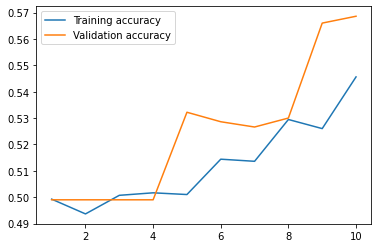

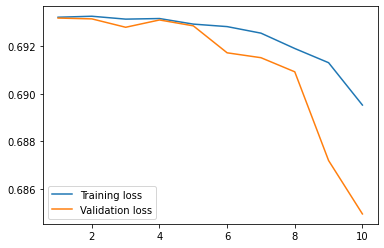

<Figure size 432x288 with 0 Axes>

In [86]:
#Accuracy Plots
plt.plot(epoch, accuracy, label='Training accuracy')
plt.plot(epoch, val_acc, label='Validation accuracy')
plt.legend()
plt.figure()

#Loss Plots
plt.plot(epoch, loss, label='Training loss')
plt.plot(epoch, val_loss, label='Validation loss')
plt.legend()
plt.figure()

plt.show()